In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn import datasets

In [2]:
x = 2 * np.random.rand(100, 1)
y = 4 + 3 * x + np.random.randn(100, 1)

<function matplotlib.pyplot.show(*args, **kw)>

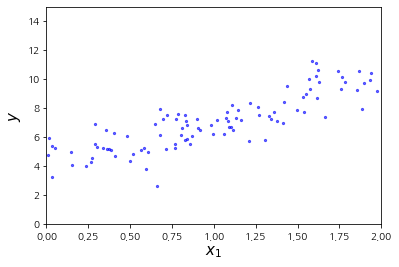

In [3]:
plt.scatter(x, y, s=5, c='b', alpha=0.6)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$y$', fontsize=15)
plt.axis([0, 2, 0, 15])
plt.show

In [4]:
# 정규방정식을 사용한 세타 계산
# numpy. c_ : 슬라이스 오브젝트를 두 번째 축을 따라 연결하도록 변환합니다.
x_b = np.c_[np.ones((100, 1)), x]
theta_best = np.linalg.inv(x_b.T.dot(x_b)).dot(x_b.T).dot(y)

In [5]:
theta_best

array([[4.07272377],
       [2.97966863]])

In [6]:
# 계산한 theta_best로 예측값 구하기
# 세타를 사용한 예측
x_new = np.array([[0], [2]])
x_new_b = np.c_[np.ones((2, 1)), x_new]
y_pred = x_new_b.dot(theta_best)
y_pred

array([[ 4.07272377],
       [10.03206104]])

<function matplotlib.pyplot.show(*args, **kw)>

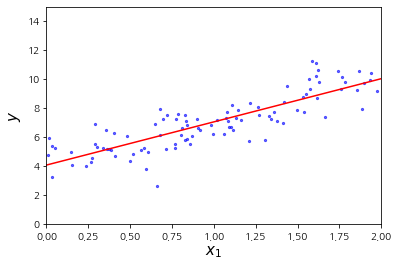

In [7]:
plt.plot(x_new, y_pred, 'r-')
plt.axis([0, 2, 0, 15])
plt.scatter(x, y, s=5, c='b', alpha=0.6)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$y$', fontsize=15)
plt.axis([0, 2, 0, 15])
plt.show

In [8]:
# 위와 같이 복잡한 공식을 사용하는 것 말고 sklearn을 사용해 간단하게 계산해보자.
# sklearn의 linearregression 모델을 이용한 회귀분석
lr = LinearRegression()
lr.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [9]:
# intercept_ : 절편, coef_ : 기울기
lr.intercept_, lr.coef_

(array([4.07272377]), array([[2.97966863]]))

In [10]:
# 위에서 직접 행렬로 계산한 식과 같은 것을 확인할 수 있다.
# predict로 x_new 값 예측, 위와 같은 것을 알 수 있다.
lr.predict(x_new)

array([[ 4.07272377],
       [10.03206104]])

In [11]:
# LinearRegression 클래스는 np.linalg.lstsq() 함수를 기반으로 하기 때문에 하이퍼파라미터를 불러올 수 있다.
# theta_best_svd : 하이퍼파라미터 (weight, bias)
# residuals : 잔차
# rank : 차수
# s : ??
theta_best_svd, residuals, rank, s = np.linalg.lstsq(x_b, y, rcond=1e-6)

In [12]:
theta_best_svd

array([[4.07272377],
       [2.97966863]])

In [13]:
# 유사역행렬을 이용하여 직접 구할 수도 있다.
np.linalg.pinv(x_b).dot(y)

array([[4.07272377],
       [2.97966863]])

In [14]:
# 배치경사하강법을 이용한 하이퍼파라미터 구하기 
# learning_rate = eta, 학습률
eta = 0.1
# 반복 횟수
n_iterations = 1000
# 행의 갯수(데이터의 갯수) : (예측값 - 실제값)^2을 m개 더한 뒤 2m으로 나누어준다.
m = 100

theta = np.random.randn(2, 1)

for iteration in range(n_iterations):
    gradients = 2/m * x_b.T.dot(x_b.dot(theta)-y)
    theta = theta -eta * gradients

In [15]:
theta

array([[4.07272377],
       [2.97966863]])

In [23]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(x_b)
    plt.scatter(x, y, c='b', alpha=0.6)
    for i in range(n_iterations):
        if i < 10:
            y_predict = x_new_b.dot(theta)
            style = 'b-' if i > 0 else 'r--'
            plt.plot(x_new, y_predict, style)
        gradients = 2/m + x_b.T.dot(x_b.dot(theta)-y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
        plt.xlabel('$x_1$', fontsize=18)
        plt.axis([0, 2, 0, 15])
        plt.title(r'$\eta = {}$'.format(eta), fontsize=16)

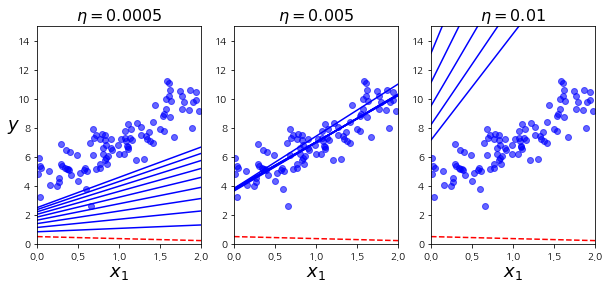

In [27]:
# learning_rate에 따른 회귀선의 변화를 그래프로 그려보았다.
# 0.005에서 가장 잘 수렴하는 것을 볼 수 있다.
# 0.0005는 과소적합된 것을 볼 수있다.
np.random.seed(42)
theta = np.random.randn(2, 1)

plt.figure(figsize=(10, 4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.0005)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.005, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.01)
plt.show()

In [28]:
# 배치 경사 하강법의 가장 큰 문제는 매 스텝에서 전체 훈련 세트를 사용한다는 사실이다.
# 그렇기 때문에 훈련 세트가 커지면 매우 느려지게 된다.

# 확률적 경사 하강법 : 매 스텝에서 한 개의 샘플을 무작위로 선택하고 그 하나의 샘플에 대한 기울기를 계산한다.
# 매 반복에서 다뤄야 할 데이터가 매우 적기 때문에 한 번에 하나의 샘플을 처리하면 알고리즘이 훨씬 빨라진다.
# 반면에 배치 경사 하강법보다 훨씬 불안정하다.
# cost 값이 최솟값에 접근할 때까지 부드럽게 감소하지 않고 요동치며 감소한다.
# 하지만 cost 함수가 매우 불규칙할 때 알고리즘이 local minimum을 뛰어 넘어 global minimum을 찾을 가능성이 배치 경사 하강법보다 높다.

# 해결방법 : learning_rate를 점진적으로 감소시키는 것이다.
# 시작할 때는 learning_rate를 크게 하고 점차 작게 줄여서 알고리즘이 global minimum에 도달하게 한다.

# 이때 훈련하는 반복을 우리는 앞으로 epoch라고 부르도록 한다.
n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = x_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2*xi.T.dot(xi.dot(theta)-yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

In [29]:
theta

array([[4.1357806 ],
       [2.96531851]])

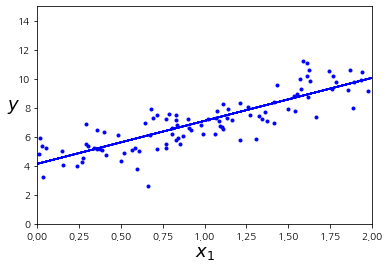

In [32]:
for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    
            y_predict = x_new_b.dot(theta)           
            style = "b-" if i > 0 else "r--"         
            plt.plot(x_new, y_predict, style)
plt.plot(x, y, "b.")                                
plt.xlabel("$x_1$", fontsize=18)                     
plt.ylabel("$y$", rotation=0, fontsize=18) 
plt.axis([0, 2, 0, 15])                                                      
plt.show()           

In [33]:
# SGD 방식에서 gradient descent
# epoch은 1000번으로 설정하고 tol은 한 epoch에서 0.001보다 적게 손실이 줄어들 때까지 실행한다.
# learning_rate는 0.1로 설정한다.
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(x, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [34]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.00578324]), array([2.92635702]))

In [36]:
# 미니배치 경사 하강법
# 미니배치라 부르는 작은 샘플을 추출한 뒤에 기울기를 계산한다.
# 장점은 행렬 연산에 최적화된 GPU에서 좋은 성능을 보인다.

theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    x_b_shuffled = x_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = x_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [37]:
theta

array([[4.1551157 ],
       [3.06941299]])

In [39]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_mgd = np.array(theta_path_mgd)

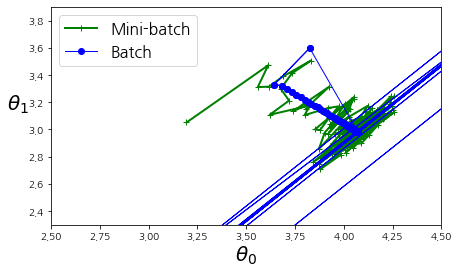

In [43]:
# 배치 경사 하강법은 그래프만 봐도 시간이 많이 걸린다는 것을 볼 수 있다.
plt.figure(figsize=(7,4))
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=1, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

In [44]:
# 다항 회귀
m = 100
x = 6 * np.random.rand(m, 1) - 3
y = 0.5 * x**2 + 2 + np.random.randn(m, 1)

In [45]:
# 이차 다항 회귀
# degree로 차수를 조정할 수 있다.
poly_features = PolynomialFeatures(degree=2, include_bias=False)
x_poly = poly_features.fit_transform(x)
x[0]

array([2.38942838])

In [46]:
x_poly[0]

array([2.38942838, 5.709368  ])

In [47]:
lr= LinearRegression()
lr.fit(x_poly, y)
lr.intercept_, lr.coef_

(array([1.9735233]), array([[-0.04961462,  0.52577032]]))

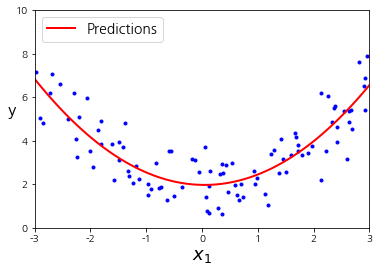

In [48]:
# 모델 곡선 그래프
x_new=np.linspace(-3, 3, 100).reshape(100, 1)
x_new_poly = poly_features.transform(x_new)
y_new = lr.predict(x_new_poly)

plt.plot(x, y, "b.")
plt.plot(x_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('y', rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

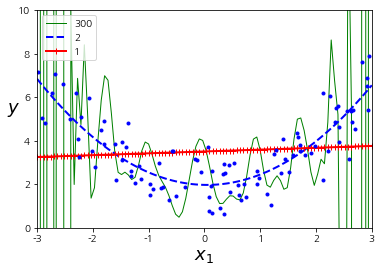

In [49]:
# 차수에 따른 그래프
# 차수가 높아질 수록 overfitting되는 것을 볼 수 있다.
for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lr = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lr),
        ])
    polynomial_regression.fit(x, y)
    y_newbig = polynomial_regression.predict(x_new)
    plt.plot(x_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(x, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [50]:
# train set 사이즈에 따른 학습 곡선
def plot_learning_curves(model, x, y):
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(x_train)):
        model.fit(x_train[:m], y_train[:m])
        y_train_predict = model.predict(x_train[:m])
        y_val_predict = model.predict(x_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='훈련 세트')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='검증 세트')
    plt.legend(loc="upper right", fontsize=14) 
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)        

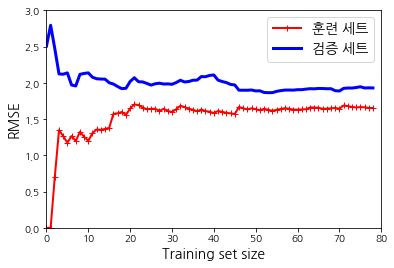

In [51]:
# 두 곡선이 수평한 구간을 만들고 꽤 높은 오차에서 매우 가까이 근접해 있다.
# 이것이 과소적합의 대표적인 예이다.
lr = LinearRegression()
plot_learning_curves(lr, x, y)
plt.axis([0, 80, 0, 3])
plt.show()

In [68]:
polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
    ('lin_reg', LinearRegression()),
])

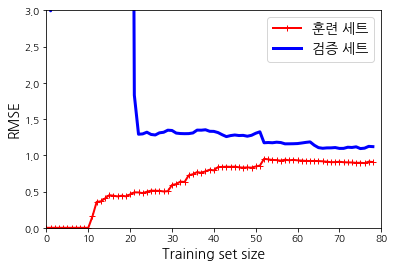

In [69]:
# 훈련데이터의 오차가 위의 선형 회귀 모델보다 훨씬 낮다.
# 두 곡선 사이에 공간이 있다. 훈련 데이터에서의 모델 성능이 검증 데이터에서보다 훨씬 낫다는 뜻이다.
# 전형적인 과대적합 모델의 특징이다.
plot_learning_curves(polynomial_regression, x, y)
plt.axis([0, 80, 0, 3])
plt.show()

In [70]:
# 과대적합 모델의 해결 방법
# 1. 테스트 셋을 많이 추가한다. => 데이터 양을 늘리게 되면 더 대표적인 모델을 뽑을 수 있다.
# 2. 여러가지 기법(정규화, 드롭-아웃 방법)들을 통해 적당한 복잡도를 가지는 모델을 찾는다.
# 3. 테스트 셋에서 noise를 줄인다.(이상치 제거)

In [97]:
# 규제가 있는 모델(라쏘, 릿지, 엘라스틱)
np.random.seed(42)
m = 20
x = 3 * np.random.rand(m, 1)
y = 1 + 0.5 + x + np.random.randn(m, 1) / 1.5
x_new = np.linspace(0, 3, 100).reshape(100, 1)

x_train, x_val, y_train, y_val = train_test_split(x[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [98]:
# 릿지 회귀 : 규제항을 추가하여 모델의 가중치가 가능한 작게 유지되도록 노력한다. alpha가 0이면 선형회귀와 같아진다.
# 릿지 회귀는 feature의 스케일에 민감하기 때문에 스케일링을 해주는 것이 중요하다.
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(x, y)
ridge_reg.predict([[1.5]])

array([[2.79702348]])

In [99]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(x, y)
ridge_reg.predict([[1.5]])

array([[2.79703796]])

In [102]:
def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ('b-', 'g--', 'r:')):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
                    ('std_scaler', StandardScaler()),
                    ('regul_reg', model)
            ])
        model.fit(x, y)
        y_new_regul = model.predict(x_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(x_new, y_new_regul, style, linewidth=lw, label=r'$\alpha = {}$'.format(alpha))
    plt.plot(x, y, 'b.', linewidth=3)
    plt.legend(loc='upper left', fontsize=15)
    plt.xlabel('$x_1$', fontsize=18)
    plt.axis([0, 3, 0, 10])

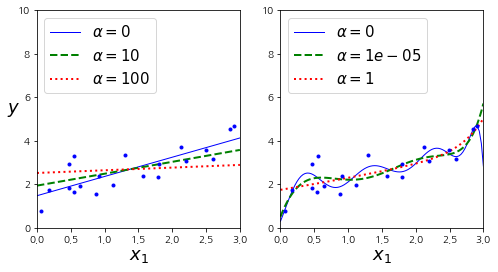

In [103]:
# 선형 회귀와 다중 회귀에서의 릿지 규제 사용
# alpha가 커질수록 모델이 직선에 가까워지는것을 확인할 수 있다.
# alpha에 따라 규제가 달라져 과접합을 방지할 수 있다.
plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel('$y$', rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.show()

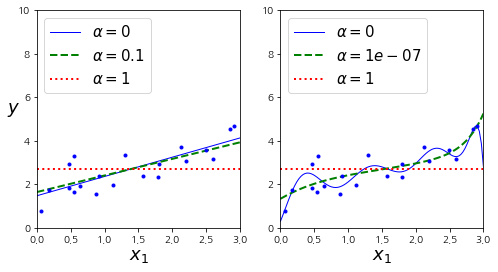

In [104]:
# 라쏘 회귀 : 규제항을 추가하여 모델의 가중치가 가능한 작게 유지되도록 노력한다. alpha가 0이면 선형회귀와 같아진다.
# 라쏘 회귀의 특징은 덜 중요한 feature의 가중치를 제거하려고 한다는 점이다.
# 자동으로 특성을 선택하고 희소 모델을 만든다.
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

plt.show()

In [106]:
# 라쏘 회귀 vs 릿지 회귀가 어떻게 수렴하는지 그래프로 알아보기
import matplotlib.pyplot as plt
import numpy as np


t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

In [107]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

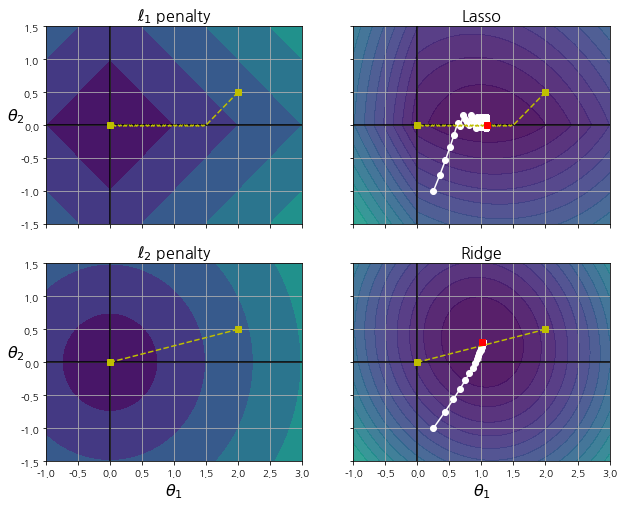

In [108]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, N / 2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)

plt.show()

In [110]:
# 엘라스틱 넷 모델
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(x, y)
elastic_net.predict([[1.5]])

array([2.78964116])

In [112]:
# 조기 종료를 위한 모델 생성
np.random.seed(42)
m = 100
x = 6 * np.random.rand(m, 1) - 3
y = 2 + x + 0.5 * x**2 + np.random.randn(m, 1)

x_train, x_val, y_train, y_val = train_test_split(x[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [113]:
# 모델 조기 종료를 위한 기본적인 구현 코드
# 조기 종료는 검증 에러가 최소에 도달하는 즉시 훈련을 멈추는 것이다.
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

x_train_poly_scaled = poly_scaler.fit_transform(x_train)
x_val_poly_scaled = poly_scaler.transform(x_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(x_train_poly_scaled, y_train)  # 중지된 곳에서 다시 시작합니다
    y_val_predict = sgd_reg.predict(x_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

In [114]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(x_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(x_train_poly_scaled)
    y_val_predict = sgd_reg.predict(x_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

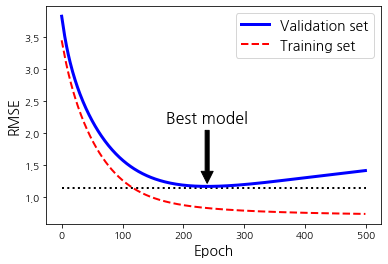

In [115]:
# 다음과 같이 Best model 구간을 넘어가면 과적합이 일어나기 때문에
# val error가 최소인 점을 찾아 종료한다.
plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

In [116]:
# 로지스틱 회귀를 위한 iris 데이터 호출
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [120]:
X = iris['data'][:, 3:]
y = (iris['target'] == 2).astype(np.int)

In [121]:
lr = LogisticRegression()
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

[0, 3, -0.02, 1.02]

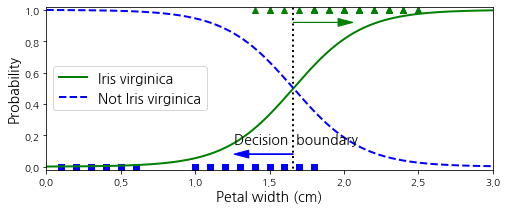

In [122]:
# 결정 경계에 따라 분류값을 변경시킬 수 있다.
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = lr.predict_proba(x_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(x[y==0], y[y==0], "bs")
plt.plot(x[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])

[2.9, 7, 0.8, 2.7]

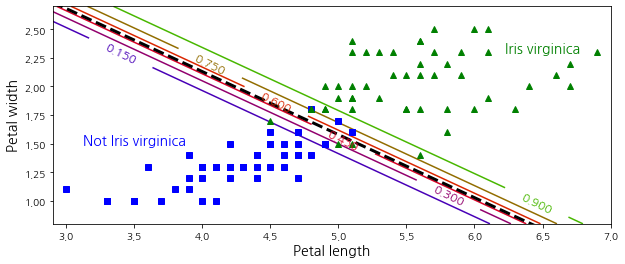

In [123]:
# virginica와 virginica가 아닌 종을 구분하는 그래프이다.
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])

In [124]:
# 소프트 맥스 회귀
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

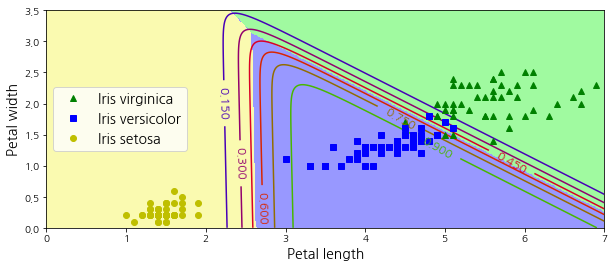

In [125]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()